## Wizualizacja danych: Projekt 2
## Jakie cechy dobrze różnicują firmy, które kontynuują działalność gospodarczą w okresie 12 miesięcy od tych, które działalności nie kontynuują?
[zmienna Target]
### Ewaluacja modelu LightGBM

In [38]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import lightgbm as lgb
from lightgbm import LGBMClassifier

from joblib import dump, load

import sys; sys.path.insert(0, '..')
from utils import evaluate

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

In [39]:
SAMPLE = None

data = pd.read_csv("../data/ceidg_data_classif.csv")
if SAMPLE:
    data = data.sample(SAMPLE)
print(data.shape)
data.head()

(2401055, 30)


,RandomDate,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,...,ShareholderInOtherCompanies,PKDMainSection,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses,Target
0,2018-03-26,May,2,MAZOWIECKIE,WARSZAWA,1465011.0,NaN,NaN,NaN,False,...,False,NaN,NaN,NaN,NaN,0,0,0,0,False
1,2018-01-10,June,2,MAZOWIECKIE,WARSZAWA,1465078.0,MAZOWIECKIE,WARSZAWA,1465078.0,True,...,False,M,71.0,711.0,7112.0,4,6,10,13,False
2,2018-03-23,June,2,MAZOWIECKIE,WARSZAWA,1465011.0,MAZOWIECKIE,WARSZAWA,1465011.0,True,...,False,C,14.0,141.0,1412.0,5,6,14,21,False
3,2018-02-13,April,2,MAZOWIECKIE,WARSZAWA,1465011.0,MAZOWIECKIE,WARSZAWA,1465011.0,True,...,False,G,46.0,461.0,4619.0,2,5,8,11,False
4,2018-03-06,December,4,MAZOWIECKIE,WARSZAWA,1465078.0,MAZOWIECKIE,WARSZAWA,1465078.0,True,...,False,C,11.0,110.0,1107.0,3,19,31,44,False


In [40]:
### DATA PREPROCESSING
categorical_variables = [
    "MonthOfStartingOfTheBusiness", 
    "MainAddressVoivodeship",
    "CorrespondenceAddressVoivodeship",
    "CorrespondenceAddressCounty",
    "PKDMainSection",
    "Sex",
    "MainAddressCounty", 
    "CommunityProperty"
]

for col in categorical_variables:
    data[col] = data[col].astype('category')

x_train, x_test, y_train, y_test = train_test_split(data.drop(["Target", "RandomDate"], axis=1), data["Target"], random_state=RANDOM_SEED)
print("Percentage of ones in target: {:.2f}% train, {:.2f}% test".format(y_train.mean()*100, y_test.mean()*100))

Percentage of ones in target: 17.23% train, 17.21% test


In [41]:
clf = LGBMClassifier(n_estimators=100)
clf.fit(x_train, y_train)

LGBMClassifier()

Accuracy: 82.92
F-1 score: 0.0342


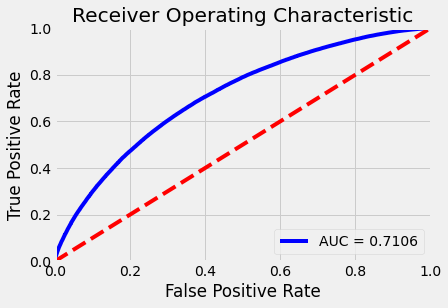

In [42]:
evaluate(clf, x_test, y_test);

In [43]:
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[495914,   1070],
       [101467,   1813]])

---
#### What features are important?

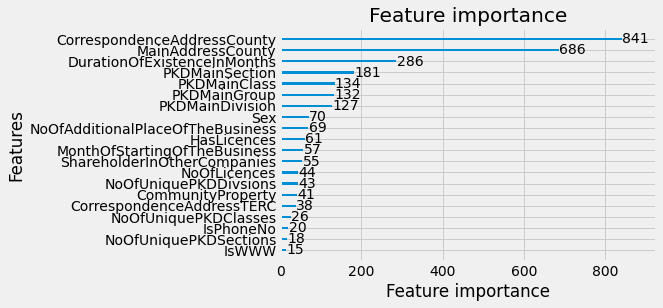

In [44]:
lgb.plot_importance(clf, max_num_features=20)

---
#### Saving model and it's predictions

In [45]:
dump(clf, '../models/lgbm.joblib')

['../models/lgbm.joblib']

In [46]:
predicted_target = clf.predict(x_test)
predicted_proba = clf.predict_proba(x_test)[:, 1]

In [47]:
x_test["PredictedTarget"] = predicted_target
x_test["PredictedProba"] = predicted_proba
x_test.to_csv("../models/x_test_lgbm.csv", index=False)

In [48]:
pd.read_csv("../models/x_test_lgbm.csv").head()

,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,DurationOfExistenceInMonths,...,PKDMainSection,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses,PredictedTarget,PredictedProba
0,August,3,LUBUSKIE,ZIELONA GóRA,862011.0,LUBUSKIE,ZIELONA GóRA,862011.0,True,31,...,M,73.0,731.0,7311.0,5,6,9,12,False,0.183107
1,April,2,POMORSKIE,GDAńSK,2261011.0,POMORSKIE,GDAńSK,2261011.0,True,24,...,F,43.0,433.0,4331.0,1,1,1,1,False,0.320213
2,March,1,PODLASKIE,BIAłYSTOK,2061011.0,PODLASKIE,BIAłYSTOK,2061011.0,True,97,...,H,53.0,532.0,5320.0,3,5,7,9,False,0.054544
3,November,4,WARMIŃSKO-MAZURSKIE,BRANIEWSKI,2802054.0,WARMIŃSKO-MAZURSKIE,BRANIEWSKI,2802054.0,True,152,...,N,81.0,812.0,8121.0,1,1,1,1,False,0.190822
4,June,2,WIELKOPOLSKIE,CZARNKOWSKO-TRZCIANECKI,3002062.0,WIELKOPOLSKIE,CZARNKOWSKO-TRZCIANECKI,3002062.0,True,151,...,C,10.0,101.0,1013.0,1,1,1,1,False,0.133076
